# Deconvolution with Distributional Consistency (DC) loss
### Plotting results

## Setup

In [1]:
# --- Set up import path ---
import sys, os

self_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(self_dir, '..', 'src'))
sys.path.insert(0, src_path)

In [2]:
from matplotlib import pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import pickle

from utils.common_utils import fix_seed
from utils.losses import dc_loss_gaussian
from utils.plotting import plot_CDF_histogram

plt.rcParams['image.interpolation'] = 'none'

SAVEFIG = False
SAVE_DIR = "../figures/deconv"

In [3]:
def noisy_blurred_signal(y_true, noise_sigma=0.1):
    N = y_true.shape[0]                # number of points in the signal

    N_ref = 500                     # reference N for sigma (initial experiments carried out with N=500, this fix allows us to rescale the blur appropriately)
    sigma_index_ref = 1.0           # original sigma at N=500
    kernel_size = 31

    # Domain-aware rescaling
    dx = 1.0 / (N - 1)
    dx_ref = 1.0 / (N_ref - 1)
    sigma_domain = sigma_index_ref * dx_ref           # convert to domain units
    blur_sigma = sigma_domain / dx                    # rescale to current N

    # Build Gaussian kernel
    kx = torch.linspace(-(kernel_size//2), kernel_size//2, kernel_size, device=dev)
    kernel = torch.exp(-0.5 * (kx / blur_sigma)**2)
    kernel /= kernel.sum()
    kernel = kernel.view(1, 1, -1)

    # Convolve and add Gaussian noise
    y_true_reshaped = y_true.view(1, 1, -1)
    y_blur = F.conv1d(F.pad(y_true_reshaped, (kernel_size//2,)*2, mode='reflect'),
                    kernel)
    y_noisy = y_blur + noise_sigma * torch.randn_like(y_blur)
    return y_blur, y_noisy

In [ ]:
results_dir = '../results/deconv'

N = 500
blur = 1.0
noise = 0.1
seed = 0
dataseed = 0

N = 128

dev = "cpu"

states = pickle.load(open(os.path.join(results_dir, f'deconvolution_N={N}_blur={blur}_noise={noise}_seed={seed}_dataseed={dataseed}_results.pkl'), 'rb'))

In [5]:
x = torch.linspace(0, 1, N)
y_true = torch.tensor(states["mse"]["y_true"])
y_noisy = states["mse"]["y_noisy"]
y_blur = states["mse"]["y_blur"]

state_mse = states["mse"]
state_dc = states["dist"]

In [6]:
N_ref = 500                     # reference N for sigma (initial experiments carried out with N=500, this fix allows us to rescale the blur appropriately)
sigma_index_ref = 1.0           # original sigma at N=500
kernel_size = 31

# Domain-aware rescaling
dx = 1.0 / (N - 1)
dx_ref = 1.0 / (N_ref - 1)
sigma_domain = sigma_index_ref * dx_ref           # convert to domain units
blur_sigma = sigma_domain / dx                    # rescale to current N

# Build Gaussian kernel
kx = torch.linspace(-(kernel_size//2), kernel_size//2, kernel_size, device=dev)
kernel = torch.exp(-0.5 * (kx / blur_sigma)**2)
kernel /= kernel.sum()
kernel = kernel.view(1, 1, -1)

In [7]:
# === PREP: Define blur function ===
def blur_signal(signal_np, kernel, kernel_size):
    signal = torch.tensor(signal_np, device=dev).view(1, 1, -1)
    blurred = F.conv1d(F.pad(signal, (kernel_size // 2,) * 2, mode='reflect'), kernel)
    return blurred.view(-1).cpu().numpy()

# === PREP: Generate _np variables ===
x_np = x.detach().cpu().numpy()
y_true_np = y_true
y_blur_np = y_blur.squeeze()
y_noisy_np = y_noisy.squeeze()

# Extract final reconstructions
x_est_mse_np = state_mse["x_est"]
x_est_dc_np  = state_dc["x_est"]

x_est_mse_blur_np = blur_signal(x_est_mse_np, kernel, kernel_size)
x_est_dc_blur_np = blur_signal(x_est_dc_np, kernel, kernel_size)

# Convolve the true signal
y_true_blur = F.conv1d(F.pad(y_true.view(1, 1, -1), (kernel_size // 2,) * 2, mode='reflect'), kernel)
y_true_blur_np = y_true_blur.view(-1).detach().cpu().numpy()

## Figures appearing in the paper

C:\Users\gw23\AppData\Local\Temp\ipykernel_42732\734581532.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


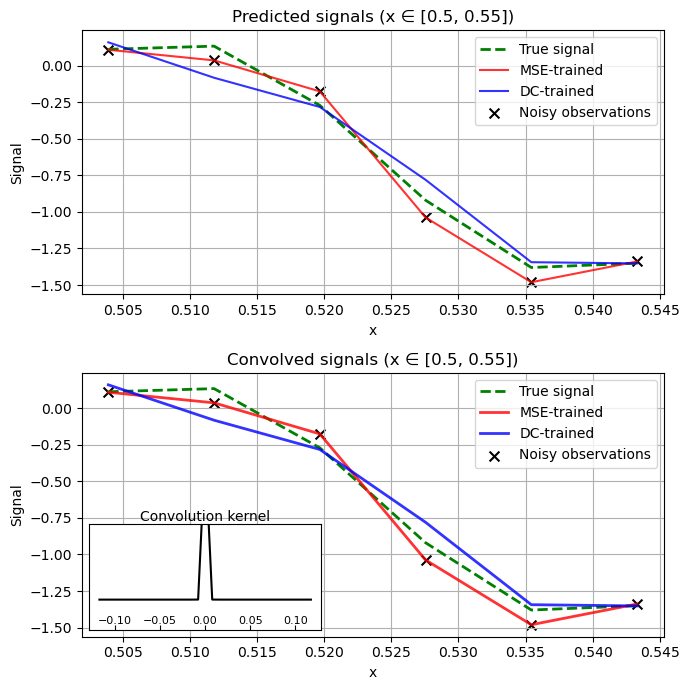

In [8]:
# Zoom range
cutout_min = 0.5
cutout_max = 0.55
mask = (x_np >= cutout_min) & (x_np <= cutout_max)

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

# --- Left subplot: Original reconstructions ---
axes[0].plot(x_np[mask], y_true_np[mask], 'g--', label='True signal', linewidth=2)
axes[0].plot(x_np[mask], x_est_mse_np[mask], 'r-', label='MSE-trained', alpha=0.8)
axes[0].plot(x_np[mask], x_est_dc_np[mask], 'b-', label='DC-trained', alpha=0.8)
axes[0].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')

axes[0].set_title('Predicted signals (x ∈ [0.5, 0.55])')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Signal')
axes[0].legend()
axes[0].grid(True)

# --- Right subplot: Blurred reconstructions only ---
axes[1].plot(x_np[mask], y_true_blur_np[mask], 'g--', label='True signal', linewidth=2)
axes[1].plot(x_np[mask], x_est_mse_blur_np[mask], 'r-', label='MSE-trained', linewidth=2, alpha=0.8)
axes[1].plot(x_np[mask], x_est_dc_blur_np[mask], 'b-', label='DC-trained', linewidth=2, alpha=0.8)
axes[1].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')

axes[1].set_title('Convolved signals (x ∈ [0.5, 0.55])')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Signal')
axes[1].legend()
axes[1].grid(True)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

kernel_np = kernel.view(-1).cpu().numpy()
kx_np     = kx.cpu().numpy() * 1 / N

in_ax = inset_axes(
    axes[1],
    width="40%",     # 40% of parent width
    height="40%",    # 40% of parent height
    loc="lower left" # move inset to bottom-left
)
in_ax.plot(kx_np, kernel_np, 'k-', linewidth=1.5)
in_ax.set_title("Convolution kernel", fontsize=10, pad=2)
in_ax.set_ylim(-0.2, 0.5)
in_ax.tick_params(axis='y', which='both', left=False, labelleft=False)
in_ax.tick_params(axis='x', direction='in', which='both', labelsize=8, pad=-10)

plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(SAVE_DIR, f"deconvolution_images.png"), bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(SAVE_DIR, f"deconvolution_images.svg"), bbox_inches='tight')
plt.show()


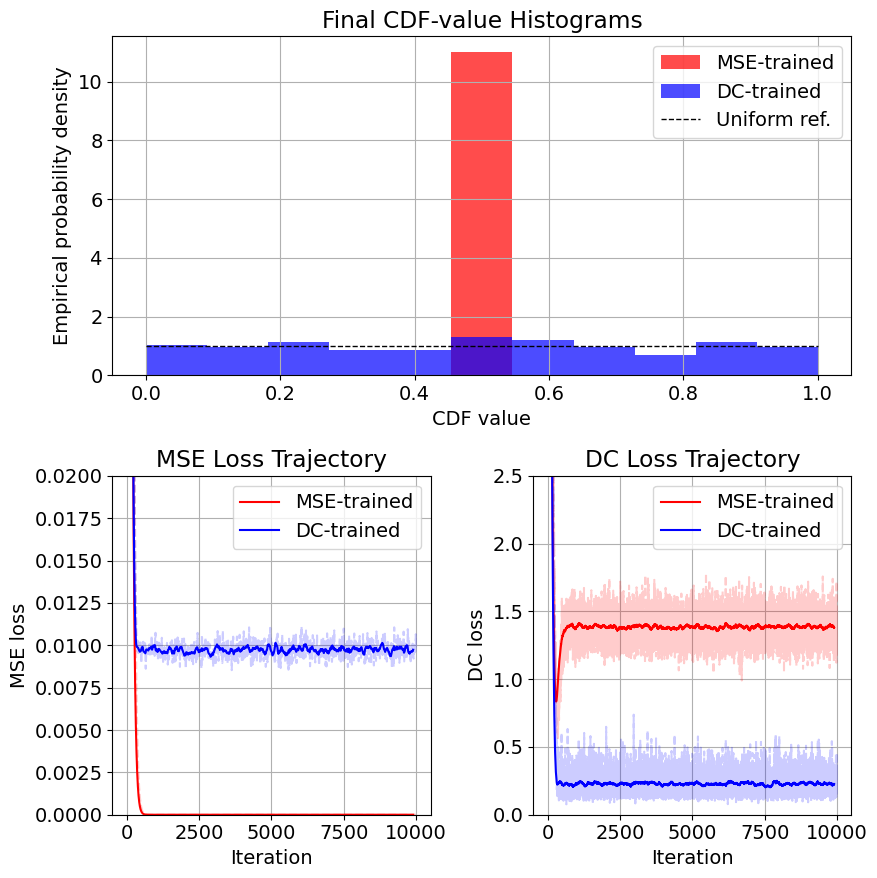

In [9]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Top row: combined histogram
ax_hist = fig.add_subplot(gs[0, :])
bins = np.linspace(0, 1, 12)  # 30 bins
for loss_name, color in [("mse", "red"), ("dist", "blue")]:
    cdf_vals, _ = states[loss_name]["histos"][-1]
    cdf_vals = 1 / (1 + np.exp(-cdf_vals))
    label = "MSE-trained" if loss_name == "mse" else "DC-trained"
    ax_hist.hist(cdf_vals, bins=bins, density=True,
                 alpha=0.7, color=color, label=label)
# uniform reference line at expected count per bin
N = len(cdf_vals)
expected = 1.0
ax_hist.hlines(expected, bins[0], bins[-1], colors='k', linestyles='--', linewidth=1, label="Uniform ref.")
ax_hist.set_title("Final CDF-value Histograms")
ax_hist.set_xlabel("CDF value")
ax_hist.set_ylabel("Empirical probability density")
#ax_hist.set_ylim(0, expected * 1.2)
ax_hist.legend()
ax_hist.grid(True)

# Bottom-left: MSE loss trajectory
ax_mse = fig.add_subplot(gs[1, 0])
for method_name, color in [("mse", "red"), ("dist", "blue")]:
    losses = np.array(states[method_name]["losses"]["mse_loss"])
    mov_avg = np.convolve(losses, np.ones(100)/100, mode='valid')
    label = "MSE-trained" if method_name == "mse" else "DC-trained"
    ax_mse.plot(mov_avg, label=f"{label}", color=color)
    ax_mse.plot(losses, linestyle='--', alpha=0.2, color=color)
ax_mse.set_title("MSE Loss Trajectory")
ax_mse.set_xlabel("Iteration")
ax_mse.set_ylabel("MSE loss")
ax_mse.set_ylim(0, 0.02)
ax_mse.legend()
ax_mse.grid(True)

# Bottom-right: DC loss trajectory
ax_dc = fig.add_subplot(gs[1, 1])
for method_name, color in [("mse", "red"), ("dist", "blue")]:
    losses = np.array(states[method_name]["losses"]["dist_loss"])
    mov_avg = np.convolve(losses, np.ones(100)/100, mode='valid')
    label = "MSE-trained" if method_name == "mse" else "DC-trained"
    ax_dc.plot(mov_avg, label=f"{label}", color=color)
    ax_dc.plot(losses, linestyle='--', alpha=0.2, color=color)
ax_dc.set_title("DC Loss Trajectory")
ax_dc.set_xlabel("Iteration")
ax_dc.set_ylabel("DC loss")
ax_dc.set_ylim(0, 2.5)
ax_dc.legend()
ax_dc.grid(True)

plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(SAVE_DIR, f"deconvolution_histograms.png"), bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(SAVE_DIR, f"deconvolution_histograms.svg"), bbox_inches='tight')
plt.show()


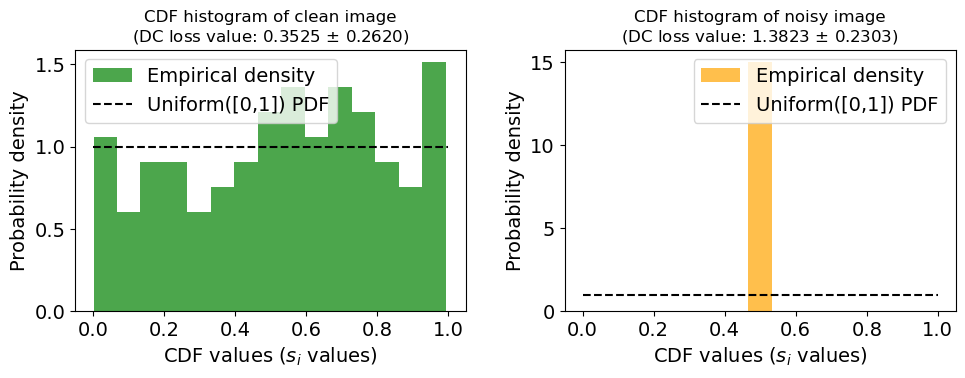

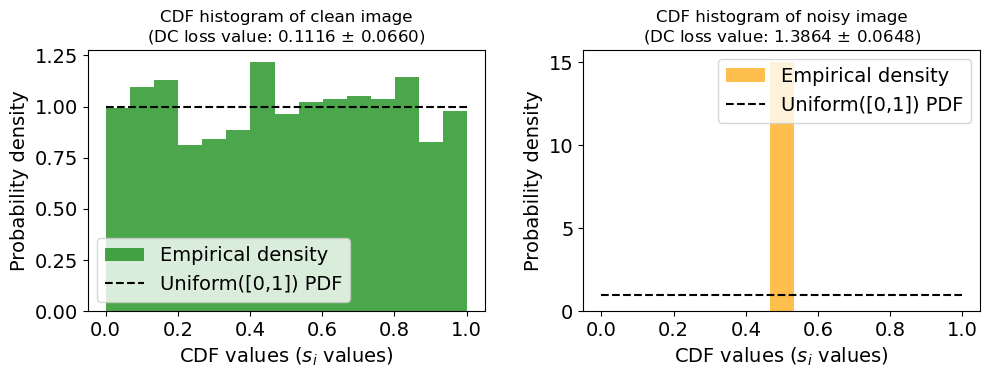

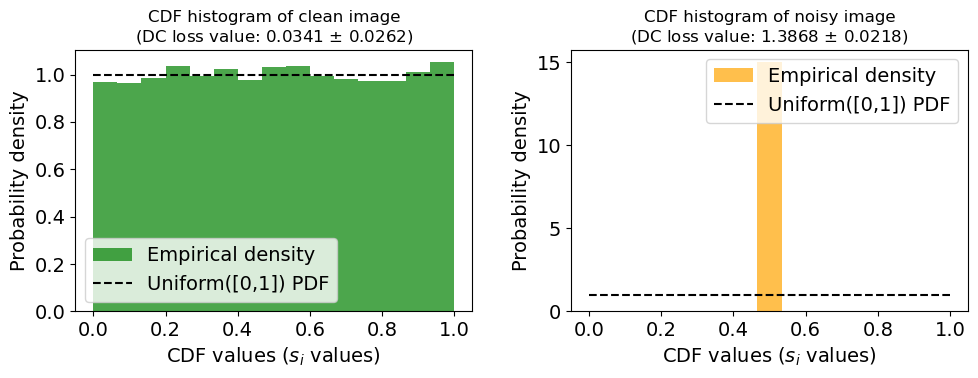

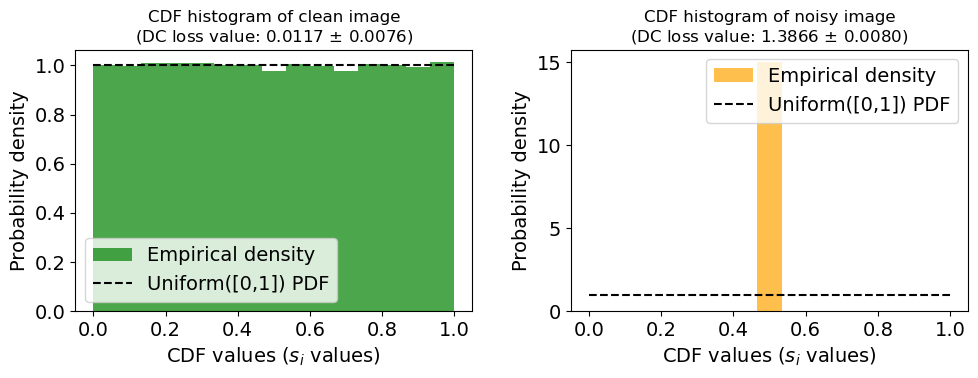

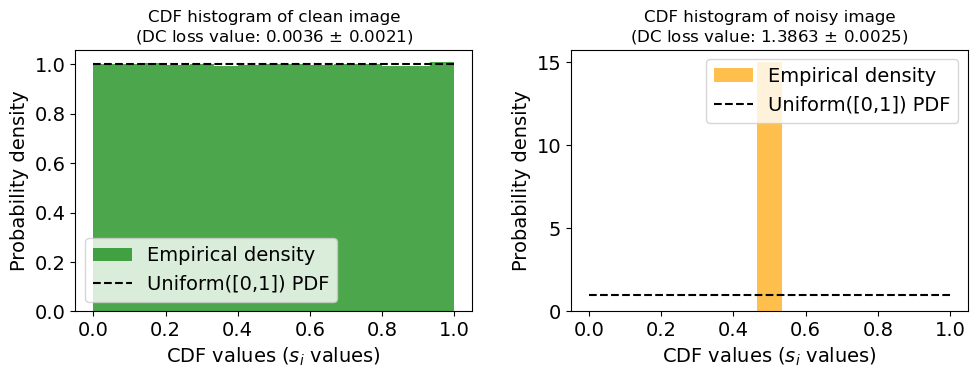

In [10]:
seed_start = 1
noise_sigma=0.1

for N in [100, 1000, 10000, 100000, 1000000]:

    x = torch.linspace(0, 1, N, device=dev)
    y_true = (torch.sin(2 * np.pi * 5 * x)
            + 0.5 * torch.sin(2 * np.pi * 20 * x)).to(dev)

    mean_dist_loss_clean = []
    mean_dist_loss_noisy = []

    for seed in range(seed_start, seed_start+100):
        fix_seed(seed)

        y_blur, y_noisy = noisy_blurred_signal(y_true, noise_sigma=noise_sigma)
        y_noisy = y_blur + noise_sigma * torch.randn_like(y_blur)

        dist_loss_value_clean, histo_values_clean, ix_clean = dc_loss_gaussian(y_blur, y_noisy, sigma=noise_sigma, return_values=True)
        mean_dist_loss_clean.append(dist_loss_value_clean.item())
        
        dist_loss_value_noisy, histo_values_noisy, ix_noisy = dc_loss_gaussian(y_noisy, y_noisy, sigma=noise_sigma, return_values=True)
        mean_dist_loss_noisy.append(dist_loss_value_noisy.item())

    mean_dist_loss_clean = np.array(mean_dist_loss_clean)
    mean_dist_loss_noisy = np.array(mean_dist_loss_noisy)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Clean image subplot
    ax[0] = plot_CDF_histogram(ax[0], histo_values_clean.cpu().numpy(), comparison="uniform", show_comparison=True, bins=15, color='green', alpha=0.7, label='Empirical density')
    ax[0].set_title("CDF histogram of clean image\n(DC loss value: " + rf"{mean_dist_loss_clean.mean():.4f} $\pm$ {mean_dist_loss_clean.std() * 1.96:.4f})", fontsize=12)

    # Noisy image subplot
    ax[1] = plot_CDF_histogram(ax[1], histo_values_noisy.cpu().numpy(), comparison="uniform", show_comparison=True, bins=15, color='orange', alpha=0.7, label='Empirical density')
    ax[1].set_title("CDF histogram of noisy image\n(DC loss value: " + rf"{mean_dist_loss_noisy.mean():.4f} $\pm$ {mean_dist_loss_noisy.std() * 1.96:.4f})", fontsize=12)
    
    #plt.suptitle(f"Histogram of CDF values for N={N}", fontsize=14)

    plt.tight_layout()
    if SAVEFIG:
        plt.savefig(os.path.join(SAVE_DIR, f"deconvolution_histograms_N={N}.png"), bbox_inches='tight', dpi=600)
    plt.show()
    plt.clf(); plt.close()


## Additional plotting

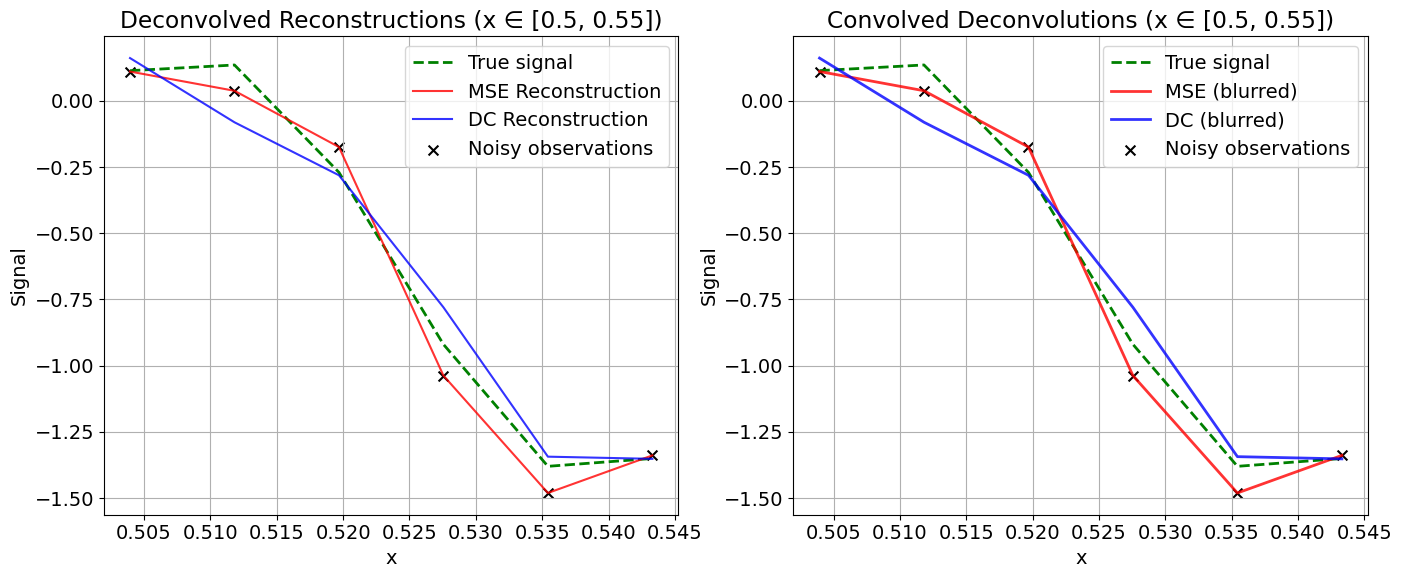

In [11]:
# === PLOT ===
cutout_min = 0.5
cutout_max = 0.55
mask = (x_np >= cutout_min) & (x_np <= cutout_max)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left subplot: Original reconstructions ---
axes[0].plot(x_np[mask], y_true_np[mask], 'g--', label='True signal', linewidth=2)
axes[0].plot(x_np[mask], x_est_mse_np[mask], 'r-', label='MSE Reconstruction', alpha=0.8)
axes[0].plot(x_np[mask], x_est_dc_np[mask], 'b-', label='DC Reconstruction', alpha=0.8)
axes[0].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')

axes[0].set_title('Deconvolved Reconstructions (x ∈ [0.5, 0.55])')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Signal')
axes[0].legend()
axes[0].grid(True)

# --- Right subplot: Blurred reconstructions only ---
axes[1].plot(x_np[mask], y_blur_np[mask], 'g--', label='True signal', linewidth=2)
axes[1].plot(x_np[mask], x_est_mse_blur_np[mask], 'r-', label='MSE (blurred)', linewidth=2, alpha=0.8)
axes[1].plot(x_np[mask], x_est_dc_blur_np[mask], 'b-', label='DC (blurred)', linewidth=2, alpha=0.8)
axes[1].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')

axes[1].set_title('Convolved Deconvolutions (x ∈ [0.5, 0.55])')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Signal')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

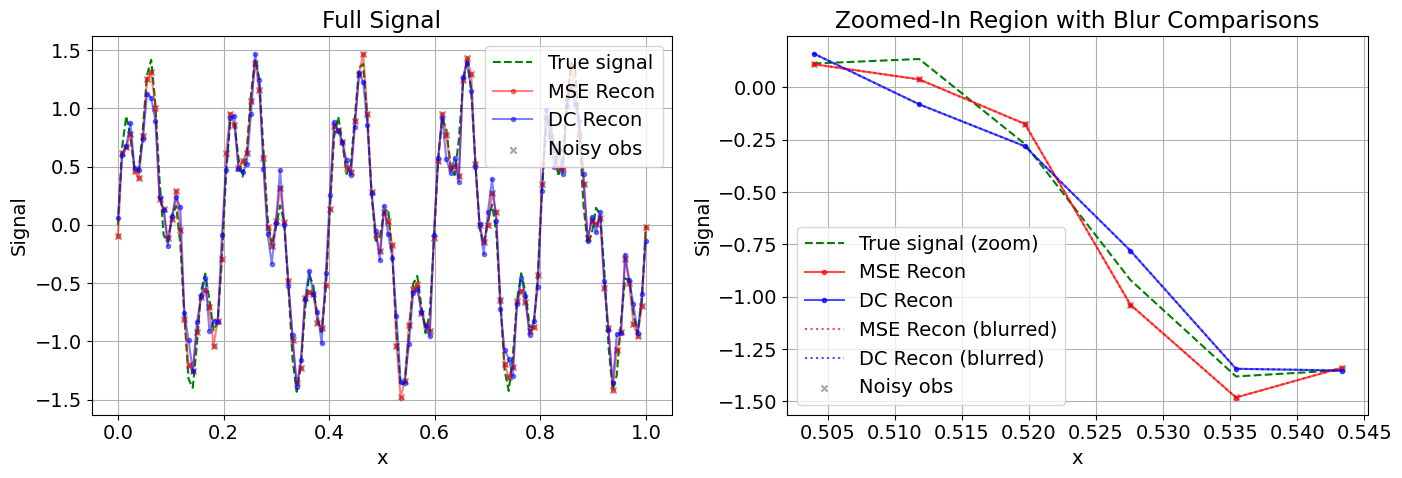

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left plot: Full signal ---
axes[0].plot(x_np, y_true_np, 'g--', label='True signal')
axes[0].plot(x_np, x_est_mse_np, 'r-', label='MSE Recon', marker='o', markersize=3, alpha=0.5)
axes[0].plot(x_np, x_est_dc_np, 'b-', label='DC Recon', marker='o', markersize=3, alpha=0.5)
axes[0].scatter(x_np, y_noisy_np, c='gray', s=20, alpha=0.7, label='Noisy obs', marker='x')
axes[0].set_title("Full Signal")
axes[0].set_xlabel("x")
axes[0].set_ylabel("Signal")
axes[0].legend()
axes[0].grid(True)

# --- Right plot: Zoomed cutout + blurred comparisons ---
cutout_min = 0.50
cutout_max = 0.55
mask = (x_np >= cutout_min) & (x_np <= cutout_max)

axes[1].plot(x_np[mask], y_true_np[mask], 'g--', label='True signal (zoom)')
axes[1].plot(x_np[mask], x_est_mse_np[mask], 'r-', label='MSE Recon', marker='o', markersize=3, alpha=0.7)
axes[1].plot(x_np[mask], x_est_dc_np[mask], 'b-', label='DC Recon', marker='o', markersize=3, alpha=0.7)
axes[1].plot(x_np[mask], x_est_mse_blur_np[mask], 'r:', label='MSE Recon (blurred)', alpha=0.7)
axes[1].plot(x_np[mask], x_est_dc_blur_np[mask], 'b:', label='DC Recon (blurred)', alpha=0.7)
axes[1].scatter(x_np[mask], y_noisy_np[mask], c='gray', s=20, alpha=0.7, label='Noisy obs', marker='x')
axes[1].set_title("Zoomed-In Region with Blur Comparisons")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Signal")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

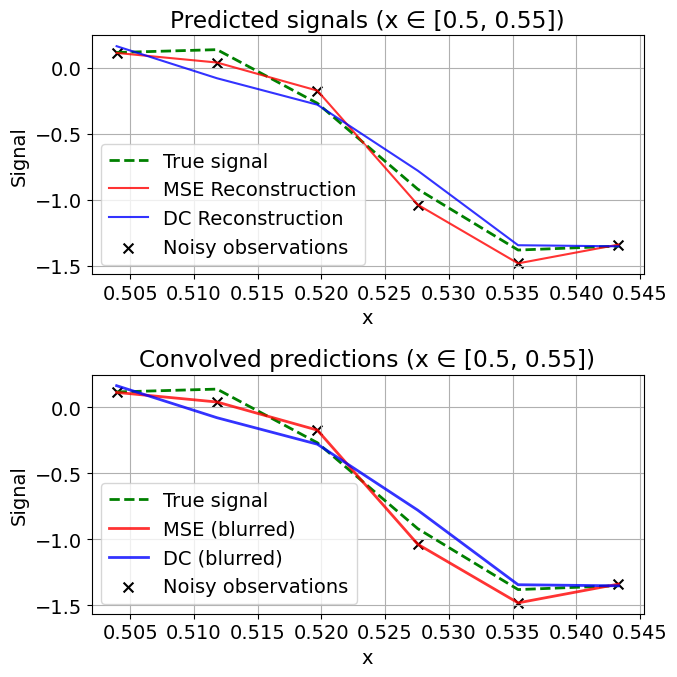

In [13]:
# Zoom range
cutout_min = 0.5
cutout_max = 0.55
mask = (x_np >= cutout_min) & (x_np <= cutout_max)

fig, axes = plt.subplots(2,1, figsize=(7, 7))

# --- Left subplot: Original reconstructions ---
axes[0].plot(x_np[mask], y_true_np[mask], 'g--', label='True signal', linewidth=2)
axes[0].plot(x_np[mask], x_est_mse_np[mask], 'r-', label='MSE Reconstruction', alpha=0.8)
axes[0].plot(x_np[mask], x_est_dc_np[mask], 'b-', label='DC Reconstruction', alpha=0.8)
axes[0].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')

axes[0].set_title('Predicted signals (x ∈ [0.5, 0.55])')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Signal')
axes[0].legend()
axes[0].grid(True)

# --- Right subplot: Blurred reconstructions only ---
axes[1].plot(x_np[mask], y_true_np[mask], 'g--', label='True signal', linewidth=2)
axes[1].plot(x_np[mask], x_est_mse_blur_np[mask], 'r-', label='MSE (blurred)', linewidth=2, alpha=0.8)
axes[1].plot(x_np[mask], x_est_dc_blur_np[mask], 'b-', label='DC (blurred)', linewidth=2, alpha=0.8)
axes[1].scatter(x_np[mask], y_noisy_np[mask], c='black', s=50, alpha=1, label='Noisy observations', marker='x')


axes[1].set_title('Convolved predictions (x ∈ [0.5, 0.55])')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Signal')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()